In [1]:
import glob, os, sys
from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [5]:
config_file = '../work_dirs/seg_compare/20221025-101345_upernet_r101-d8_480x480_320k_irfissure-fusion-mixup/upernet_r101-d8_480x480_320k_irfissure-fusion-mixup.py'
checkpoint_file = '../work_dirs/seg_compare/20221025-101345_upernet_r101-d8_480x480_320k_irfissure-fusion-mixup/latest.pth'
source_foldes = ['../data/custom_dataset/IR_fissure/fusion/images/improved_ddcgan']

In [6]:
# build the model from a config file and a checkpoint file
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

load checkpoint from local path: ../work_dirs/seg_compare/20221025-101345_upernet_r101-d8_480x480_320k_irfissure-fusion-mixup/latest.pth


In [4]:
def collect_images(*paths):
    def collect(path):
        images = []

        # glob multiple filetypes
        for ext in ['*.jpg', '*.png', '*.jpeg']:
            images.extend(glob.glob(os.path.join(path, ext)))

        images.sort()
        return images

    return [collect(path) for path in paths]

In [5]:
imgs = collect_images(*source_foldes)
result_root = os.path.dirname(checkpoint_file)
os.makedirs(os.path.join(result_root, 'results'), exist_ok=True)

In [7]:
for i, source_folder in enumerate(source_foldes):
    for j, img_path in enumerate(imgs[i]):
        img_name = os.path.splitext(os.path.basename(img_path))[0]
        result = inference_segmentor(model, img_path)
        model.show_result(img_path, result, palette=None, out_file=os.path.join(result_root, 'results', img_name + ".jpg"), opacity=0.8)

In [9]:
# test a single image
img = '../data/custom_dataset/IR_fissure/fusion/images/improved_ddcgan/20201015_161259_888_R.png'
result = inference_segmentor(model, img)

/home/ranhui/Workspace/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


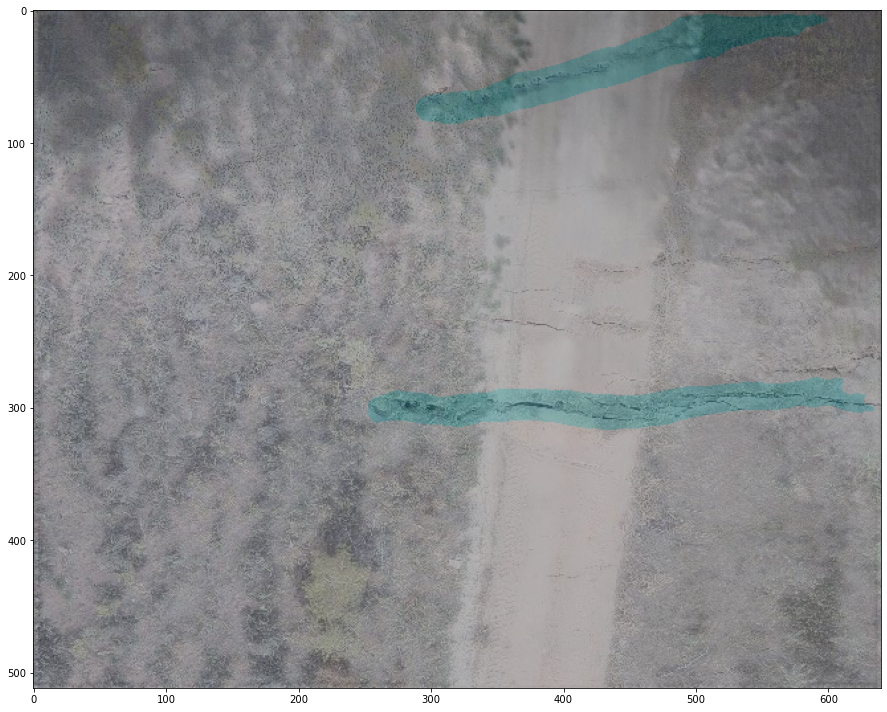

In [10]:
# show the results
show_result_pyplot(model, img, result)